In [0]:
%run "/Users/zhouzi.hu@paulaschoice.com/core_func"

In [0]:
from pyspark.sql import SparkSession
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
# Preprocessing 
spark=SparkSession.builder.getOrCreate()
raw=spark.read.csv('/mnt/datalake/raw/dtc/input data for ml projects/Imported Raw Input/dda-1414 raw input for new ml.csv',header=True)
raw=raw.toPandas()
dropna_df=raw.dropna(axis=0)
dropna_df.head(5)

,CompanyId,DistSKUcnt,Ordercnt,average_basket_size,cohort,AOV,DistCampaigncnt(past2yrs),MonthlyAvgRev(past2yrs),Have_subscription_history?,Churn? (2 months)
0,1000919,65,128,2.59,2012,58.7588,15,72.2011,1,0
1,1010611,31,52,5.13,2013,104.703,3,145.40,0,0
2,1010667,94,213,3.34,2012,92.18,14,151.7785,1,0
3,1010818,21,59,2.12,2013,41.763,1,39.741,1,0
4,1000003,24,19,3.37,2013,58.6578,1,96.425,0,0


In [0]:
# count total input data
total_rows = len(dropna_df)
print("Total rows:", total_rows)

Total rows: 459161


In [0]:
# sampling
percentage = 0.1
sample_df= random_sample(dropna_df,percentage)
sample_df.head(5)

,CompanyId,DistSKUcnt,Ordercnt,average_basket_size,cohort,AOV,DistCampaigncnt(past2yrs),MonthlyAvgRev(past2yrs),Have_subscription_history?,Churn? (2 months)
0,3515796,10,2,5.00,2023,149.575,0,299.15,0,0
1,3494689,3,1,3.00,2022,34.85,0,34.85,0,0
2,3408788,1,1,1.00,2022,12.00,0,12.00,0,0
3,3050667,2,2,1.00,2021,20.55,2,20.55,0,1
4,3494057,1,1,1.00,2022,10.40,0,10.40,0,0


In [0]:
# Obtain a list of the column headers
col_names = sample_df.columns.tolist()
# Check if feature columns have been applied correctly
print(col_names)

['CompanyId', 'DistSKUcnt', 'Ordercnt', 'average_basket_size', 'cohort', 'AOV', 'DistCampaigncnt(past2yrs)', 'MonthlyAvgRev(past2yrs)', 'Have_subscription_history?', 'Churn? (2 months)']


In [0]:
# Isolate target data
churn_result=sample_df['Churn? (2 months)']
# Get a Boolean Label of the Churn Result
y=np.asarray(churn_result)
# Remove columns that are not required
to_drop=['CompanyId','Churn? (2 months)']
churn_feat_space=sample_df.drop(to_drop,axis=1)
# Pull out features for future use
features=churn_feat_space.columns
# Getting Feature List for training in the future
X=churn_feat_space.values.astype(np.float64)

In [0]:
# Standardize features by removing the mean and scaling to unit variance
scaler=StandardScaler()
X=scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))
#### End of Preprocessing of Data Points

Feature space holds 45916 observations and 8 features
Unique target labels: ['0' '1']


In [0]:
# Start Testing Models
print("\nTesting Models (Accuracy):")
print("Support vector machines:")
print("%.3f" % accuracy(y,run_cv(X,y,SVC)))
print("Random forest:")
print("%.3f" % accuracy(y,run_cv(X,y,RF)))
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y,run_cv(X,y,KNN)))
print("Gradient Boosting Classifier:")
print("%.3f" % accuracy(y,run_cv(X,y,GBC)))


Testing Models (Accuracy):
Support vector machines:


In [0]:
# confusion matrix & f1-score

class_names = np.unique(y)

models = [
    ("Support Vector Machines", SVC),
    ("Random Forest", RF),
    ("K-Nearest-Neighbors", KNN),
    ("Gradient Boosting Classifier", GBC)
]

results = []

for model_name, model in models:
    # Run cross-validation and get predicted labels
    predicted_labels = run_cv(X, y, model)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y, predicted_labels)
    
    # Calculate F1 score
    f1 = f1_score(y, predicted_labels, average='weighted')
    
    # Append classifier, confusion matrix, and F1 score to results list
    results.append((model_name, cm, f1))

# Display Confusion Matrix Graphic and F1 Score
for model_name, cm, f1 in results:
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: ' + model_name)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.show()

    # Print F1 score
    print(f"F1 Score - {model_name}: {f1}")
    print(f"Confusion Matrix - {model_name}:\n{cm}")

In [0]:
warnings.filterwarnings('ignore')
# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, GBC, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == '1'
# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
# calculate True probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)
# Join Dataframes
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob','count','true_prob']
print(counts.head(20))


    pred_prob  count  true_prob
0    0.256299   3997   0.284964
1    0.260639   3743   0.281592
2    0.252211   3430   0.295335
3    0.233069   1155   0.195671
4    0.346056    897   0.321070
5    0.336865    886   0.366817
6    0.337952    823   0.348724
7    0.250790    713   0.186536
8    0.243769    648   0.291667
9    0.248905    633   0.347551
10   0.162661    629   0.143084
11   0.081885    585   0.000000
12   0.083208    537   0.000000
13   0.124140    533   0.031895
14   0.242834    522   0.227969
15   0.211767    485   0.241237
16   0.081734    479   0.000000
17   0.182104    460   0.158696
18   0.206724    444   0.146396
19   0.259050    442   0.280543


In [0]:
# Get Results
print ("Support vector machines:")
print_measurements(run_prob_cv(X, y, SVC, probability=True))
print ("Random forests:")
print_measurements(run_prob_cv(X, y, RF, n_estimators=18))
print ("K-nearest-neighbors:")
print_measurements(run_prob_cv(X, y, KNN))
print ("Gradient Boosting Classifier:")
print_measurements(run_prob_cv(X, y, GBC))

Feature Ranking:
1. DistSKUcnt (0.391555)
2. Ordercnt (0.251974)
3. average_basket_size (0.199821)
4. cohort (0.101422)
5. AOV (0.025454)
6. DistCampaigncnt(past2yrs) (0.017930)
7. MonthlyAvgRev(past2yrs) (0.009098)
8. Have_subscription_history? (0.002746)


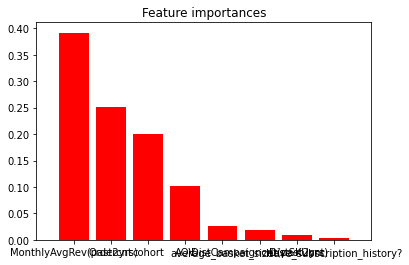

In [0]:
# Feature Importances ranking
train_index, test_index = train_test_split(sample_df.index)
GBC_M = GBC()
GBC_M_fit=GBC_M.fit(X[train_index], y[train_index])
GBC_predictions=GBC_M_fit.predict(X[test_index])
importances = GBC_M.feature_importances_[:8]
indices = np.argsort(importances)[::-1]

print("Feature Ranking:")
for f in range(8):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(8), importances[indices], color="r", align="center")
plt.xticks(range(8), [features[i] for i in indices])
plt.xlim([-1, 8])
plt.show()

In [0]:
# ROC

print("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print("K-nearest-neighbors:")
plot_roc(X,y,KNN)

print("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

In [0]:
print ("Logistic Regression:")
print ("%.3f" % accuracy(y, run_cv(X,y,LR)))
print ("Gradient Boosting Classifier")
print ("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print ("Support vector machines:")
print ("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print ("Random forest:")
print ("%.3f" % accuracy(y, run_cv(X,y,RF)))
print ("K-nearest-neighbors:")
print ("%.3f" % accuracy(y, run_cv(X,y,KNN)))

In [0]:

pred_prob= run_prob_cv(X,y,GBC,n_estimators=10)
pred_churn=pred_prob[:,1]
is_churn = y == '1'

counts=pd.value_counts(pred_churn)
counts[:]

from collections import defaultdict
true_prob = defaultdict(float)

for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

counts = pd.concat([counts, true_prob], axis=1).reset_index()
counts.columns = ['pred_prob','count','true_prob']
counts.head(50)


,pred_prob,count,true_prob
0,0.258609,4032,0.285218
1,0.255047,3475,0.295827
2,0.259228,3361,0.284737
3,0.235695,1141,0.190184
4,0.340488,874,0.352403
5,0.355629,870,0.329885
6,0.344708,862,0.353828
7,0.252776,660,0.319697
8,0.245103,643,0.300156
9,0.238155,642,0.207165
